# Double/Debiased ML for Partially Linear IV Model

References: 

https://arxiv.org/abs/1608.00060


https://www.amazon.com/Business-Data-Science-Combining-Accelerate/dp/1260452778

The code is based on the book.



# Partially Linear IV Model

We consider the partially linear structural equation model:
\begin{eqnarray}
 &  Y - D\theta_0 = g_0(X) + \zeta,  & E[\zeta \mid Z,X]= 0,\\
  & Z = m_0(X) +  V,   &  E[V \mid X] = 0. 
\end{eqnarray}


Note that this model is not a regression model unless $Z=D$.  The model  is a canonical
model in causal inference, going back to P. Wright's work on IV methods for estimaing demand/supply equations, with the modern difference being that $g_0$ and $m_0$ are nonlinear, potentially complicated functions of high-dimensional $X$.  


The idea of this model is that there is a structural or causal relation between $Y$ and $D$, captured by $\theta_0$, and $g_0(X) + \zeta$ is the stochastic error, partly explained by covariates $X$.  $V$ and $\zeta$ are stochastic errors that are not explained by $X$. Since $Y$ and $D$ are jointly determined, we need an external factor, commonly referred to as an instrument, $Z$ to create exogenous variation
in $D$.   Note that $Z$ should affect $D$.  The $X$ here serve again as confounding factors, so we can think of variation in $Z$ as being exogenous only conditional on $X$. 


The causal DAG this model corresponds to is given by:
$$
Z \to D,  X \to (Y, Z, D),  L \to (Y,D),
$$
where $L$ is the latent confounder affecting both $Y$ and $D$, but not $Z$.



---

# Example

A simple contextual example is from biostatistics, where $Y$ is a health outcome and $D$ is indicator of smoking.  Thus, $\theta_0$ is captures the effect of smoking on health.  Health outcome $Y$ and smoking behavior $D$ are treated as being jointly determined.  $X$ represents patient characteristics, and $Z$ could be a doctor's advice not to smoke (or another behavioral treatment) that may affect the outcome $Y$ only through shifting the behavior $D$, conditional on characteristics $X$.   

----



# PLIVM in Residualized Form

The PLIV model above can be rewritten in the following residualized form:
$$
  \tilde Y = \tilde D \theta_0 + \zeta,   \quad  E[\zeta \mid V,X]= 0,
$$
where
$$
 \tilde Y = (Y- \ell_0(X)),  \quad \ell_0(X) = E[Y \mid X] \\
   \tilde D = (D - r_0(X)), \quad r_0(X) = E[D \mid X] \\
   \tilde Z = (Z- m_0(X)), \quad m_0(X) = E[Z \mid X].
$$
   The tilded variables above represent original variables after taking out or "partialling out"
  the effect of $X$.  Note that $\theta_0$ is identified from this equation if $V$ 
  and $U$ have non-zero correlation, which automatically means that $U$ and $V$
  must have non-zero variation.

  

-----

# DML for PLIV Model

Given identification, DML  proceeds as follows

Compute the estimates $\hat \ell_0$, $\hat r_0$, and $\hat m_0$ , which amounts
to solving the three problems of predicting $Y$, $D$, and $Z$ using
$X$, using any generic  ML method, giving us estimated residuals 
$$
\tilde Y = Y - \hat \ell_0(X), \\ \tilde D= D - \hat r_0(X), \\ \tilde Z = Z- \hat m_0(X).
$$ 
The estimates should be of a cross-validated form, as detailed in the algorithm below. 

Estimate $\theta_0$ by the the intstrumental
variable regression of $\tilde Y$ on $\tilde D$ using $\tilde Z$ as an instrument.
Use the conventional inference for the IV regression estimator, ignoring
the estimation error in these residuals. 

The reason we work with this residualized form is that it eliminates the bias
arising when solving the prediction problem in stage 1. The role of cross-validation
is to avoid another source of bias due to potential overfitting.

The estimator is adaptive,
in the sense that the first stage estimation errors do not affect the second 
stage errors.


In [1]:
install.packages("hdm")
install.packages("AER")
install.packages("randomForest")

Installing package into 'C:/Users/Anzony/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'hdm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Anzony\AppData\Local\Temp\RtmpCcpXlF\downloaded_packages


Installing package into 'C:/Users/Anzony/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'AER' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Anzony\AppData\Local\Temp\RtmpCcpXlF\downloaded_packages


Installing package into 'C:/Users/Anzony/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'randomForest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Anzony\AppData\Local\Temp\RtmpCcpXlF\downloaded_packages


In [30]:

library(AER)  #applied econometrics library
library(randomForest)  #random Forest library
library(hdm) #high-dimensional econometrics library
library(glmnet) #glm net


# DML for PLIVM

DML2.for.PLIVM <- function(x, d, z, y, dreg, yreg, zreg, nfold=2) {
  # this implements DML2 algorithm, where there moments are estimated via DML, before constructing
  # the pooled estimate of theta randomly split data into folds
  nobs <- nrow(x)
  foldid <- rep.int(1:nfold,times = ceiling(nobs/nfold))[sample.int(nobs)]
  I <- split(1:nobs, foldid)
  # create residualized objects to fill
  ytil <- dtil <- ztil<- rep(NA, nobs)
  # obtain cross-fitted residuals
  cat("fold: ")
  for(b in 1:length(I)){
    dfit <- dreg(x[-I[[b]],], d[-I[[b]]])  #take a fold out
    zfit <- zreg(x[-I[[b]],], z[-I[[b]]])  #take a fold out
    yfit <- yreg(x[-I[[b]],], y[-I[[b]]])  # take a folot out
    dhat <- predict(dfit, x[I[[b]],], type="response")  #predict the fold out
    zhat <- predict(zfit, x[I[[b]],], type="response")  #predict the fold out
    yhat <- predict(yfit, x[I[[b]],], type="response")  #predict the fold out
    dtil[I[[b]]] <- (d[I[[b]]] - dhat) #record residual
    ztil[I[[b]]] <- (z[I[[b]]] - zhat) #record residual
    ytil[I[[b]]] <- (y[I[[b]]] - yhat) #record residial
    cat(b," ")
    print(dim( x[-I[[b]],]))
  }
  ivfit= tsls(y=ytil,d=dtil, x=NULL, z=ztil, intercept=FALSE)
  coef.est <-  ivfit$coef          #extract coefficient 
  se <-  ivfit$se                  #record standard error
  cat(sprintf("\ncoef (se) = %g (%g)\n", coef.est , se))
  return( list(coef.est =coef.est , se=se, dtil=dtil, ytil=ytil, ztil=ztil) )
}



-----

# Emprical Example:  Acemoglu, Jonsohn, Robinson (AER).


* Y is log GDP;
* D is a measure of Protection from Expropriation, a proxy for 
quality of insitutions;
* Z is the log of Settler's mortality;
* W are geographical variables (latitude, latitude squared, continent dummies as well as interactions)



In [31]:
data(AJR)
save(AJR, file = "../data/ajr.RData")

In [32]:
data(AJR); 

y = AJR$GDP; 
d = AJR$Exprop; 
z = AJR$logMort
xraw= model.matrix(~ Latitude+ Africa+Asia + Namer + Samer, data=AJR)
x = model.matrix(~ -1 + (Latitude + Latitude2 + Africa + 
                           Asia + Namer + Samer)^2, data=AJR)
dim(x)

[1] 64 21

In [57]:

data(AJR); 

y = AJR$GDP; 
d = AJR$Exprop; 
z = AJR$logMort
xraw= model.matrix(~ Latitude+ Africa+Asia + Namer + Samer, data=AJR)
x = model.matrix(~ -1 + (Latitude + Latitude2 + Africa + 
                           Asia + Namer + Samer)^2, data=AJR)
dim(x)

# DML with Random Forest
cat(sprintf("\n DML with Random Forest \n"))

dreg <- function(x,d){ randomForest(x, d) }  #ML method=Forest
yreg <- function(x,y){ randomForest(x, y) }  #ML method=Forest
zreg<-  function(x,z){ randomForest(x, z)}  #ML method=Forest 
  
set.seed(1)
DML2.RF = DML2.for.PLIVM(xraw, d, z, y, dreg, yreg, zreg, nfold=20)

# DML with PostLasso
cat(sprintf("\n DML with Post-Lasso \n"))

dreg <- function(x,d){ rlasso(x, d) }  #ML method=lasso
yreg <- function(x,y){ rlasso(x, y) }  #ML method=lasso
zreg<-  function(x,z){ rlasso(x, z)}  #ML method=lasso 

set.seed(1)
DML2.lasso = DML2.for.PLIVM(x, d, z, y, dreg, yreg, zreg, nfold=20)


# Compare Forest vs Lasso

comp.tab= matrix(NA, 3, 2)
comp.tab[1,] = c( sqrt(mean((DML2.RF$ytil)^2)),  sqrt(mean((DML2.lasso$ytil)^2)) )
comp.tab[2,] = c( sqrt(mean((DML2.RF$dtil)^2)),  sqrt(mean((DML2.lasso$dtil)^2)) )
comp.tab[3,] = c( sqrt(mean((DML2.RF$ztil)^2)),  sqrt(mean((DML2.lasso$ztil)^2)) )
rownames(comp.tab) = c("RMSE for Y:", "RMSE for D:", "RMSE for Z:")
colnames(comp.tab) = c("RF", "LASSO")
print(comp.tab, digits=3)

[1] 64 21


 DML with Random Forest 
fold: 1  [1] 60  6
2  [1] 60  6
3  [1] 60  6
4  [1] 60  6
5  [1] 61  6
6  [1] 61  6
7  [1] 61  6
8  [1] 61  6
9  [1] 61  6
10  [1] 61  6
11  [1] 61  6
12  [1] 61  6
13  [1] 61  6
14  [1] 61  6
15  [1] 61  6
16  [1] 61  6
17  [1] 61  6
18  [1] 61  6
19  [1] 61  6
20  [1] 61  6

coef (se) = 0.885958 (0.325226)

 DML with Post-Lasso 
fold: 1  [1] 60 21
2  [1] 60 21
3  [1] 60 21
4  [1] 60 21
5  [1] 61 21
6  [1] 61 21
7  [1] 61 21
8  [1] 61 21
9  [1] 61 21
10  [1] 61 21
11  [1] 61 21
12  [1] 61 21
13  [1] 61 21
14  [1] 61 21
15  [1] 61 21
16  [1] 61 21
17  [1] 61 21
18  [1] 61 21
19  [1] 61 21
20  [1] 61 21

coef (se) = 0.711469 (0.173174)
               RF LASSO
RMSE for Y: 0.775 0.871
RMSE for D: 1.275 1.544
RMSE for Z: 0.912 1.046


In [36]:
library("readxl")
data2 = read_excel("../data/data2.xlsx")

In [42]:
x1 = data2[ , 1:21 ]

In [44]:
y1 = data2$Exprop

In [50]:
lm( y1 ~ 1)


Call:
lm(formula = y1 ~ 1)

Coefficients:
(Intercept)  
      6.507  


In [45]:
model1 = rlasso( x1 , y1 )

In [55]:
dim(x1)

[1] 61 21

In [52]:
model1$coef

intercept           Latitude          Latitude2             Africa 
                 0                  0                  0                  0 
              Asia              Namer              Samer Latitude:Latitude2 
                 0                  0                  0                  0 
   Latitude:Africa      Latitude:Asia     Latitude:Namer     Latitude:Samer 
                 0                  0                  0                  0 
  Latitude2:Africa     Latitude2:Asia    Latitude2:Namer    Latitude2:Samer 
                 0                  0                  0                  0 
       Africa:Asia       Africa:Namer       Africa:Samer         Asia:Namer 
                 0                  0                  0                  0 
        Asia:Samer        Namer:Samer 
                 0                  0

In [49]:
mean(y1)

[1] 6.506557

In [48]:
(predict( model1 , x1, type="response"))

[1] 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557
 [9] 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557
[17] 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557
[25] 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557
[33] 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557
[41] 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557
[49] 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557 6.506557
[57] 6.506557 6.506557 6.506557 6.506557 6.506557

# Examine if we have weak instruments

In [20]:
install.packages("lfe")
library(lfe)
summary(felm(DML2.lasso$dtil~DML2.lasso$ztil), robust=T)
summary(felm(DML2.RF$dtil~DML2.RF$ztil), robust=T)

Warning message:
"package 'lfe' is in use and will not be installed"



Call:
   felm(formula = DML2.lasso$dtil ~ DML2.lasso$ztil) 

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1611 -1.0202  0.1249  1.0021  3.0360 

Coefficients:
                 Estimate Robust s.e t value Pr(>|t|)   
(Intercept)      0.000105   0.179497   0.001  0.99954   
DML2.lasso$ztil -0.587550   0.204111  -2.879  0.00547 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.439 on 62 degrees of freedom
Multiple R-squared(full model): 0.1584   Adjusted R-squared: 0.1448 
Multiple R-squared(proj model): 0.1584   Adjusted R-squared: 0.1448 
F-statistic(full model, *iid*):11.67 on 1 and 62 DF, p-value: 0.001127 
F-statistic(proj model): 8.286 on 1 and 62 DF, p-value: 0.005475 




Call:
   felm(formula = DML2.RF$dtil ~ DML2.RF$ztil) 

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7411 -0.9755  0.0012  0.7718  3.2164 

Coefficients:
             Estimate Robust s.e t value Pr(>|t|)  
(Intercept)   0.01578    0.15670   0.101   0.9201  
DML2.RF$ztil -0.35243    0.18945  -1.860   0.0676 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.254 on 62 degrees of freedom
Multiple R-squared(full model): 0.06352   Adjusted R-squared: 0.04842 
Multiple R-squared(proj model): 0.06352   Adjusted R-squared: 0.04842 
F-statistic(full model, *iid*):4.205 on 1 and 62 DF, p-value: 0.04453 
F-statistic(proj model): 3.461 on 1 and 62 DF, p-value: 0.06759 



#  We do have weak instruments, because t-stats in regression $\tilde D \sim \tilde Z$ are less than 4 in absolute value

So let's carry out DML inference combined with Anderson-Rubin Idea

In [58]:
# DML-AR (DML with Anderson-Rubin) 

DML.AR.PLIV<- function(rY, rD, rZ, grid, alpha=.05){
    n = length(rY)
    Cstat = rep(0, length(grid))
    for (i in 1:length(grid)) {
    Cstat[i] <-  n* (mean( (rY - grid[i]*rD)*rZ)  )^2/var ( (rY - grid[i]*rD) * rZ )
    };
    LB<- min(grid[ Cstat < qchisq(1-alpha,1)]);
    UB <- max(grid[ Cstat < qchisq(1-alpha,1)]); 
    plot(range(grid),range(c( Cstat)) , type="n",xlab="Effect of institutions", ylab="Statistic", main=" ");  
    lines(grid, Cstat,   lty = 1, col = 1);       
    abline(h=qchisq(1-alpha,1), lty = 3, col = 4);
    abline(v=LB, lty = 3, col = 2);
    abline(v=UB, lty = 3, col = 2);
    return(list(UB=UB, LB=LB))
    }


In [68]:
rY = DML2.lasso$ytil
rD= DML2.lasso$dtil
rZ= DML2.lasso$ztil
grid = seq(-2, 2, by =.01)

In [69]:
n = length(rY)
Cstat = rep(0, length(grid))
for (i in 1:length(grid)) {
Cstat[i] <-  n* (mean( (rY - grid[i]*rD)*rZ)  )^2/var ( (rY - grid[i]*rD) * rZ )
}

In [72]:
var ( (rY - grid[1]*rD) * rZ )

[1] 25.04505

$UB
[1] 1.74

$LB
[1] 0.44

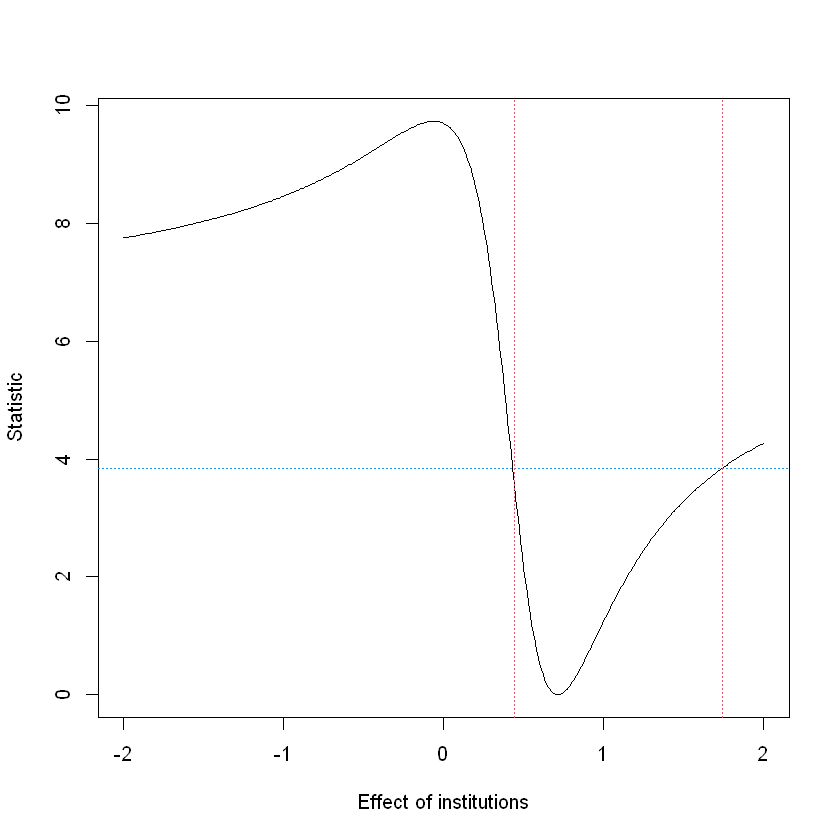

$UB
[1] 2

$LB
[1] 0.36

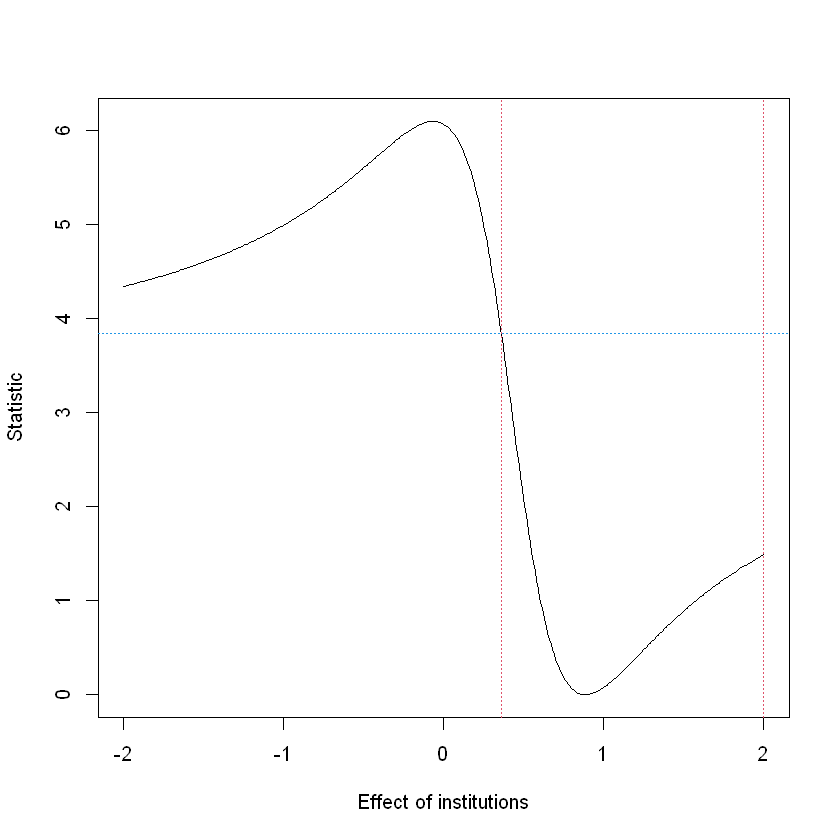

In [60]:
DML.AR.PLIV(rY = DML2.lasso$ytil, rD= DML2.lasso$dtil, rZ= DML2.lasso$ztil,
           grid = seq(-2, 2, by =.01))


DML.AR.PLIV(rY = DML2.RF$ytil, rD= DML2.RF$dtil, rZ= DML2.RF$ztil,
           grid = seq(-2, 2, by =.01))
